In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from Model import Model
from PlaceInputs import PlaceInputs
from utils import *
import configs

# Parameters and Initialization

In [2]:
# Parameters
N_inp = 5000
N_bar = 5000
num_states = 100

In [3]:
place_inputs = PlaceInputs(N_inp, num_states).get_inputs()
model = Model(
    N_inp, N_bar, num_states,
    narrow_search_factor=0., wide_search_factor=1.5,
    )

In [4]:
cache_states = [20, 35, 70]

In [5]:
identification_s = 0.0

# Visualize difference in performance

### Full recall strength

Now I just cached at location: 20


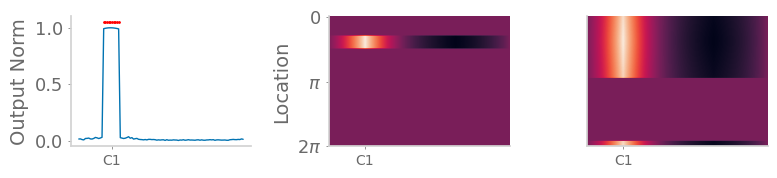

Now I just cached at location: 35


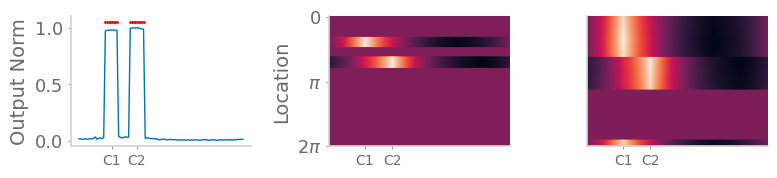

Now I just cached at location: 70


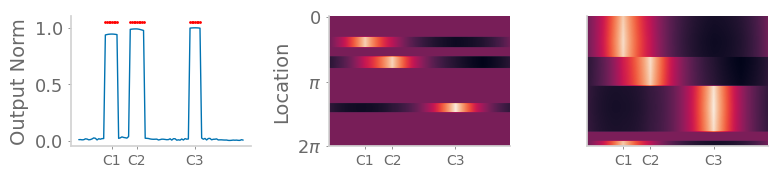

In [6]:
model.reset()

cache_identification = []
narrow_recall = []
wide_recall = []

for c_idx, cache_state in enumerate(cache_states):
    
    print("Now I just cached at location:", cache_state)
    preacts, acts, _, acts_over_time = model.run_recurrent(place_inputs, n_zero_input=20)
    model.update(place_inputs[cache_state], acts[cache_state], preacts[cache_state])

    _, _, _cache_identification, _ = model.run_recall(identification_s, place_inputs)
    cache_identification.append(_cache_identification.copy())
    
    _, _, _narrow_recall, _ = model.run_narrow_recall(place_inputs)
    narrow_recall.append(_narrow_recall.copy())
    
    _, _, _wide_recall, _ = model.run_wide_recall(place_inputs)
    wide_recall.append(_wide_recall.copy())

    recall_plots(_cache_identification, _narrow_recall, _wide_recall, cache_states[:c_idx+1])

### Low recall strength

Now I just cached at location: 20


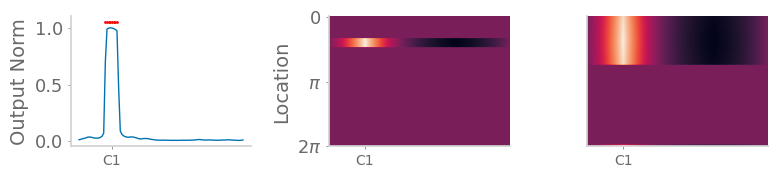

Now I just cached at location: 35


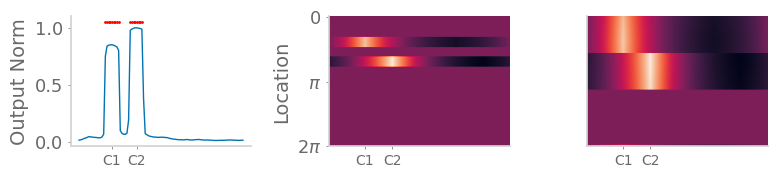

Now I just cached at location: 70


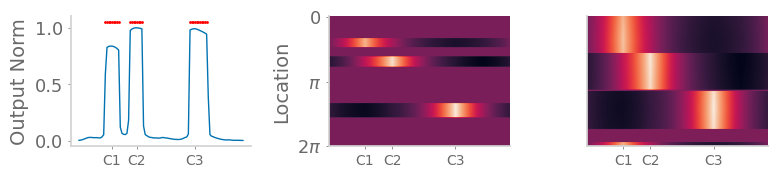

In [8]:
model.reset()
rec_strength = 0.5

cache_identification = []
narrow_recall = []
wide_recall = []

for c_idx, cache_state in enumerate(cache_states):
    
    print("Now I just cached at location:", cache_state)
    preacts, acts, _, acts_over_time = model.run_recurrent(place_inputs, n_zero_input=20)
    model.update(place_inputs[cache_state], acts[cache_state], preacts[cache_state])

    _, _, _cache_identification, _ = model.run_recall(
        identification_s, place_inputs, rec_strength=rec_strength)
    cache_identification.append(_cache_identification.copy())
    
    _, _, _narrow_recall, _ = model.run_narrow_recall(place_inputs)
    narrow_recall.append(_narrow_recall.copy())
    
    _, _, _wide_recall, _ = model.run_wide_recall(place_inputs)
    wide_recall.append(_wide_recall.copy())

    recall_plots(_cache_identification, _narrow_recall, _wide_recall, cache_states[:c_idx+1])

# Quantify difference in performance

In [23]:
results = {
    'Recall Strength': [],
    'Accuracy': [],
    'False Positive': [],
    'False Negative': [],
    'True Positive': [],
    'True Negative': [],
    }


correct_labels = np.zeros(num_states)
correct_labels[cache_states] = 1.
noncache_states = np.ones(num_states).astype(bool)
noncache_states[cache_states] = False
for iteration in range(40):
    print(f'Iteration {iteration}')
    model.reset()
    for c_idx, cache_state in enumerate(cache_states):
        preacts, acts, _, acts_over_time = model.run_recurrent(place_inputs, n_zero_input=20)
        model.update(place_inputs[cache_state], acts[cache_state], preacts[cache_state])
    for rec_strength in np.arange(0.1, 1.1, 0.1):
        _, _, _cache_identification, _ = model.run_recall(
            identification_s, place_inputs, rec_strength=rec_strength)
        readout = np.linalg.norm(_cache_identification, axis=1)
        readout /= readout.max()
        readout = (readout > 0.5).astype(float)
        
        acc = np.sum(readout == correct_labels)/num_states
        fp = np.sum(readout[noncache_states])/(num_states - len(cache_states))
        tn = 1. - fp
        fn = np.sum(readout[cache_states]==0.)/len(cache_states)
        tp = 1. - fn
        
        results['Recall Strength'].append(rec_strength)
        results['Accuracy'].append(acc)
        results['False Positive'].append(fp)
        results['False Negative'].append(fn)
        results['True Positive'].append(tp)
        results['True Negative'].append(tn)

Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26
Iteration 27
Iteration 28
Iteration 29
Iteration 30
Iteration 31
Iteration 32
Iteration 33
Iteration 34
Iteration 35
Iteration 36
Iteration 37
Iteration 38
Iteration 39


In [25]:
df = pd.DataFrame(results)

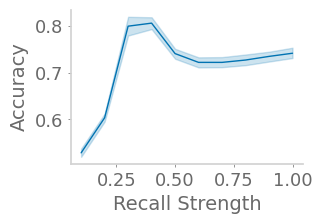

In [26]:
plt.figure(figsize=(3,2))
sns.lineplot(y='Accuracy', x='Recall Strength', data=df)
plt.show()

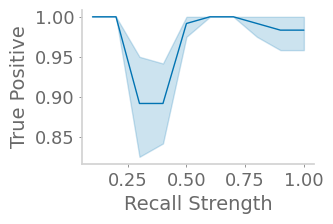

In [27]:
plt.figure(figsize=(3,2))
sns.lineplot(y='True Positive', x='Recall Strength', data=df)
plt.show()

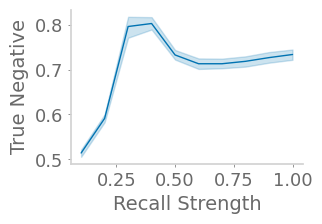

In [28]:
plt.figure(figsize=(3,2))
sns.lineplot(y='True Negative', x='Recall Strength', data=df)
plt.show()